<a href="https://colab.research.google.com/github/Volodymyr301/enterprise-samples/blob/master/Practice_5_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded 300 images across 3 categories.


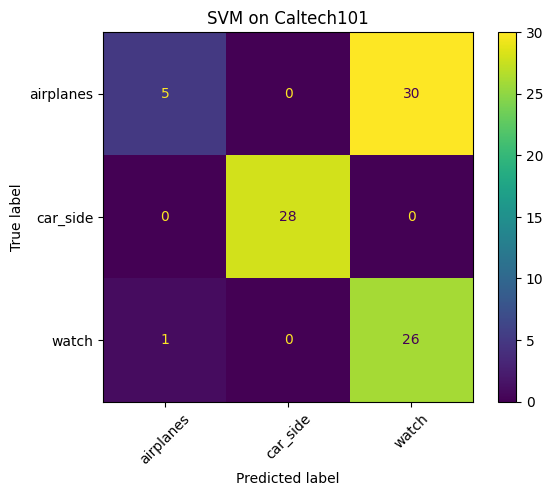

Accuracy for SVM on Caltech101: 0.6556
Classification Report:
              precision    recall  f1-score   support

   airplanes       0.83      0.14      0.24        35
    car_side       1.00      1.00      1.00        28
       watch       0.46      0.96      0.63        27

    accuracy                           0.66        90
   macro avg       0.77      0.70      0.62        90
weighted avg       0.77      0.66      0.59        90



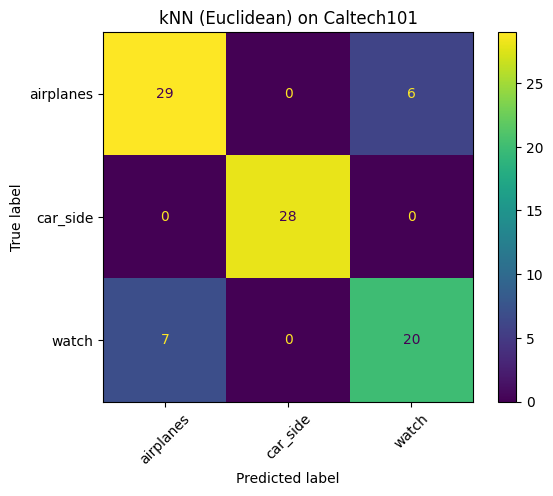

Accuracy for kNN (Euclidean) on Caltech101: 0.8556
Classification Report:
              precision    recall  f1-score   support

   airplanes       0.81      0.83      0.82        35
    car_side       1.00      1.00      1.00        28
       watch       0.77      0.74      0.75        27

    accuracy                           0.86        90
   macro avg       0.86      0.86      0.86        90
weighted avg       0.86      0.86      0.86        90



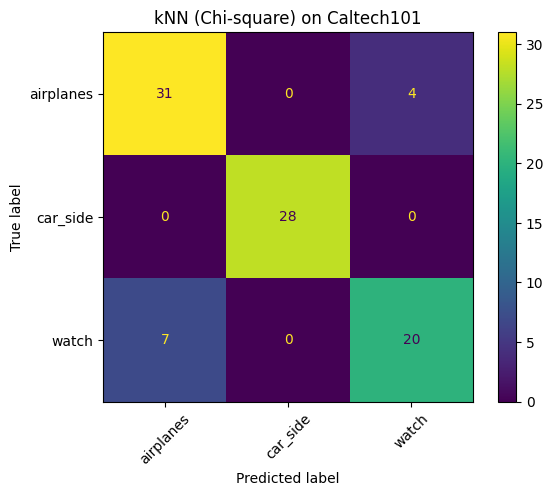

Accuracy for kNN (Chi-square) on Caltech101: 0.8778
Classification Report:
              precision    recall  f1-score   support

   airplanes       0.82      0.89      0.85        35
    car_side       1.00      1.00      1.00        28
       watch       0.83      0.74      0.78        27

    accuracy                           0.88        90
   macro avg       0.88      0.88      0.88        90
weighted avg       0.88      0.88      0.88        90



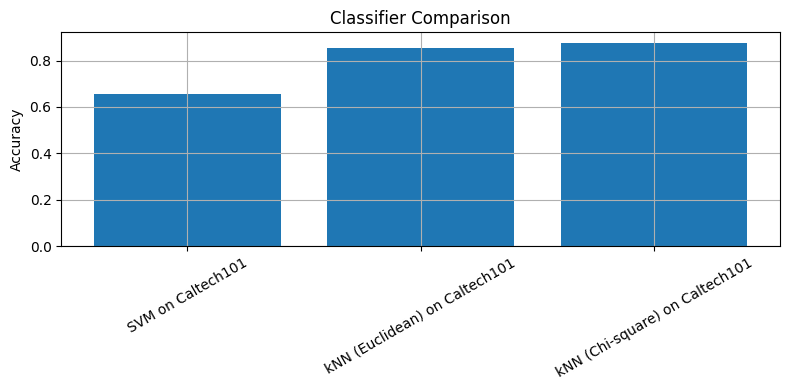

In [2]:
# Bag of Words classification pipeline for Caltech101 dataset

import os
import cv2
import zipfile
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Define dataset paths and URLs
CALTECH_URL = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
CALTECH_ZIP = "caltech-101.zip"
BASE_DIR = "caltech101"
TAR_FILE = os.path.join(BASE_DIR, "caltech-101", "101_ObjectCategories.tar.gz")
DATASET_PATH = os.path.join(BASE_DIR, "101_ObjectCategories")

# Download and extract archive
def download_and_extract_caltech101():
    if not os.path.exists(TAR_FILE):
        print("Downloading caltech-101.zip...")
        urllib.request.urlretrieve(CALTECH_URL, CALTECH_ZIP)
        print("Extracting ZIP archive...")
        with zipfile.ZipFile(CALTECH_ZIP, 'r') as zip_ref:
            zip_ref.extractall(BASE_DIR)
    if not os.path.exists(DATASET_PATH):
        print("Extracting 101_ObjectCategories.tar.gz...")
        with tarfile.open(TAR_FILE, "r:gz") as tar:
            tar.extractall(path=BASE_DIR)

# Execute extraction
download_and_extract_caltech101()

# Configuration
CATEGORIES = ['airplanes', 'car_side', 'faces', 'watch']
IMAGES_PER_CLASS = 100
IMAGE_SIZE = (128, 128)
POINTS_PER_IMAGE = 50
SCALES = [1, 2, 4, 8, 16]
K_CLUSTERS = 100

# Load dataset
def load_images():
    images = []
    labels = []
    loaded = []
    for idx, category in enumerate(CATEGORIES):
        files = glob(os.path.join(DATASET_PATH, category, '*.jpg'))[:IMAGES_PER_CLASS]
        if not files:
            print(f"Warning: No images found for {category}")
            continue
        loaded.append(category)
        for file in files:
            img = cv2.imread(file)
            if img is not None:
                img = cv2.resize(img, IMAGE_SIZE)
                images.append(img)
                labels.append(len(loaded) - 1)
    return np.array(images), np.array(labels), loaded

images, labels, loaded_categories = load_images()
print(f"Loaded {len(images)} images across {len(loaded_categories)} categories.")

if len(images) == 0:
    raise ValueError("No images loaded.")

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Feature extraction: convolution-based descriptors
from scipy.ndimage import gaussian_filter, laplace, sobel

def extract_filtered_features(img, keypoints):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    descriptors = []
    for scale in SCALES:
        gauss = np.stack([gaussian_filter(img_lab[..., c], sigma=scale) for c in range(3)], axis=-1)
        lap = np.stack([laplace(gauss[..., c]) for c in range(3)], axis=-1)
        grad_x = np.stack([sobel(gauss[..., c], axis=1) for c in range(3)], axis=-1)
        grad_y = np.stack([sobel(gauss[..., c], axis=0) for c in range(3)], axis=-1)
        for (y, x) in keypoints:
            v = np.concatenate([
                gauss[y, x], lap[y, x], grad_x[y, x], grad_y[y, x]
            ])
            descriptors.append(v)
    return np.array(descriptors)

# Select keypoints randomly
def select_random_points(img, num_points):
    h, w = img.shape[:2]
    return [(np.random.randint(5, h-5), np.random.randint(5, w-5)) for _ in range(num_points)]

# Extract all descriptors from training set
all_descriptors = []
image_keypoints = []
for img in X_train:
    kp = select_random_points(img, POINTS_PER_IMAGE)
    desc = extract_filtered_features(img, kp)
    image_keypoints.append((kp, desc))
    all_descriptors.append(desc)

all_descriptors = np.vstack(all_descriptors)

# Cluster descriptors to form visual vocabulary
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42)
kmeans.fit(all_descriptors)

# Build histogram for each image
def build_histogram(desc):
    words = kmeans.predict(desc)
    hist, _ = np.histogram(words, bins=range(K_CLUSTERS + 1), density=True)
    return hist

X_train_hist = np.array([build_histogram(desc) for _, desc in image_keypoints])

# Build histograms for test set
X_test_hist = []
for img in X_test:
    kp = select_random_points(img, POINTS_PER_IMAGE)
    desc = extract_filtered_features(img, kp)
    hist = build_histogram(desc)
    X_test_hist.append(hist)

X_test_hist = np.array(X_test_hist)

# Chi-square distance function
def chi2_distance(a, b):
    return 0.5 * np.sum(((a - b) ** 2) / (a + b + 1e-10))

# kNN using chi-square distance
def knn_chi2(X_train, X_test, y_train, k=5):
    predictions = []
    for test_hist in X_test:
        dists = [chi2_distance(test_hist, train_hist) for train_hist in X_train]
        indices = np.argsort(dists)[:k]
        nearest_labels = [y_train[i] for i in indices]
        pred = max(set(nearest_labels), key=nearest_labels.count)
        predictions.append(pred)
    return np.array(predictions)

# Classifiers
svm = SVC(kernel='linear')
svm.fit(X_train_hist, y_train)
y_pred_svm = svm.predict(X_test_hist)

knn_euc = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_euc.fit(X_train_hist, y_train)
y_pred_knn_euc = knn_euc.predict(X_test_hist)

y_pred_knn_chi2 = knn_chi2(X_train_hist, X_test_hist, y_train)

# Evaluation
results = []

def evaluate(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title(title)
    plt.show()
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy for {title}: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))
    results.append((title, acc))

# Display evaluation
evaluate(y_test, y_pred_svm, "SVM on Caltech101", labels=loaded_categories)
evaluate(y_test, y_pred_knn_euc, "kNN (Euclidean) on Caltech101", labels=loaded_categories)
evaluate(y_test, y_pred_knn_chi2, "kNN (Chi-square) on Caltech101", labels=loaded_categories)

# Plot accuracy comparison
titles, accuracies = zip(*results)
plt.figure(figsize=(8, 4))
plt.bar(titles, accuracies)
plt.ylabel("Accuracy")
plt.title("Classifier Comparison")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()
